# Electricity grid with storage.
The town of Hamilton buys its electricity from the Powerco utility, which charges for electricity on
an hourly basis. If less than 50 MWh is used during a given hour, then the cost is \\$100 per MWh. Any
excess beyond 50 MWh used during the hour is charged at the higher rate of \\$400 per MWh. The
maximum power that Powerco can provide in any given hour is 75 MWh. Here is what the average
daily electricity demand looks like for Hamilton during the month of January:

|Hour of day (AM)| 1| 2| 3| 4| 5| 6| 7| 8| 9|10|11|12|
|----------------|--|--|--|--|--|--|--|--|--|--|--|--|
|&nbsp;          |43|40|36|36|35|38|41|46|49|48|47|47|

|Hour of day (PM)| 1| 2| 3| 4| 5| 6| 7| 8| 9|10|11|12|
|----------------|--|--|--|--|--|--|--|--|--|--|--|--|
|&nbsp;          |48|46|45|47|50|63|75|75|72|66|57|50|

### a. Run the following script to simulate the town

In [2]:
def buy_electricity(amount):
    if amount > 50:
        print("50 MWh x $100/MWh = ${:>6}".format(5000));
        print("{:2.2f} MWh x $400/MWh = ${:>6}".format(float(amount - 50), float(400 * (amount - 50))))
        return (100 * 50) + (400 * (amount - 50))
    else:
        print("{:2.2f} MWh x $100/MWh = ${:>6}".format(float(amount), float(amount * 100)))
        return 100 * amount
    
daily_need = [43, 40, 36, 36, 35, 38, 41, 46, 49, 48, 47, 47, 48, 46, 45, 47, 50, 63, 75, 75, 72, 66, 57, 50]

cost = 0

for amount in daily_need:
    cost += buy_electricity(amount)

previous_cost = cost

print("Town has to pay     ${:>6}".format(cost))

43.00 MWh x $100/MWh = $4300.0
40.00 MWh x $100/MWh = $4000.0
36.00 MWh x $100/MWh = $3600.0
36.00 MWh x $100/MWh = $3600.0
35.00 MWh x $100/MWh = $3500.0
38.00 MWh x $100/MWh = $3800.0
41.00 MWh x $100/MWh = $4100.0
46.00 MWh x $100/MWh = $4600.0
49.00 MWh x $100/MWh = $4900.0
48.00 MWh x $100/MWh = $4800.0
47.00 MWh x $100/MWh = $4700.0
47.00 MWh x $100/MWh = $4700.0
48.00 MWh x $100/MWh = $4800.0
46.00 MWh x $100/MWh = $4600.0
45.00 MWh x $100/MWh = $4500.0
47.00 MWh x $100/MWh = $4700.0
50.00 MWh x $100/MWh = $5000.0
50 MWh x $100/MWh = $  5000
13.00 MWh x $400/MWh = $5200.0
50 MWh x $100/MWh = $  5000
25.00 MWh x $400/MWh = $10000.0
50 MWh x $100/MWh = $  5000
25.00 MWh x $400/MWh = $10000.0
50 MWh x $100/MWh = $  5000
22.00 MWh x $400/MWh = $8800.0
50 MWh x $100/MWh = $  5000
16.00 MWh x $400/MWh = $6400.0
50 MWh x $100/MWh = $  5000
7.00 MWh x $400/MWh = $2800.0
50.00 MWh x $100/MWh = $5000.0
Town has to pay     $152400


### b. Increasing concerns

The mayor of Hamilton is concerned because the high electricity use during evening hours is costing
the city a lot of money. There is also risk of black-outs at around 7pm because the average demand is
dangerously close to Powerco’s 75 MW limit.
To address these issues, the mayor purchased a large battery with a storage capacity of 30 MWh. The
idea is that extra electricity could be purchased early in the day (at the lower rate), stored in the
battery, and used later in the day when demand (and prices) are high. The battery is not perfectly
efficient – 1% of the stored power is lost each hour.<br>

However, mayor requires your help to decide the time and amount of electricity to buy. Are you up for the challenge? Complete the following model and help mayor saving money!<br>

- Mayor needs to know how much electricity should be bought for each hour. Complete the following model using a decision variable named __buy__
- Any order that exceeds the demand will be stored in the battery if the battery is not full


In [3]:
import numpy as np
import sys
from gamspy import (
    Container,Set,Alias,Parameter,Variable,Equation,Model,Problem,Sense,Options,
    Domain,Number,Sum,Product,Smax,Smin,Ord,Card,ModelStatus,SpecialValues
)
from gamspy.exceptions import GamspyException

m = Container()

hr = Set(m,'hr', records=[ str(i + 1) for i in range(24) ])
demand = Parameter(m,'demand',[hr],records=np.array(daily_need))
battery_capacity = 30
battery_efficiency = 0.99
max_xl = 50
max_power = 75

xl = Variable(m,'xl','positive',[hr],description='Generation -- low cost in period hr')
xh = Variable(m,'xh','positive',[hr],description='Generation -- high cost in period hr')
b = Variable(m,'b','positive',[hr],description='Battery storage at start of period')
buy = Variable(m,'buy','positive',[hr],description='Purchase amount in period hr')

xl.up = 50
b.up = 30

#Equations
# Missing that look into the future, When demand is 75 aren't available to buy on spot. 
# Not draining from b[hr] when the battery is used

b.fx[hr].where[hr.first] = 0

resource_con = Equation(m, 'resource_con', domain=[hr])
resource_con[hr] = buy[hr] == xl[hr] + xh[hr]

battery_update = Equation(m, 'battery_update', domain=[hr])
battery_update[hr] = b[hr] == ((b[hr.lag(1, 'circular')] * battery_efficiency) - (demand[hr]) + xl + xh)

# power_capacity = Equation(m, 'power_capacity', domain=[hr])
# power_capacity[hr] = xl[hr] + xh[hr] <= max_power

powerco = Model(m,
    name='powerco',
    equations=m.getEquations(),
    problem=Problem.LP,
    sense=Sense.MIN,
    objective= Sum(hr, 100*xl[hr] + 400*xh[hr]))

In [4]:
# BUILD powerco model in this cell using variables above
powerco.solve(options=Options(equation_listing_limit=100))              
print("Objective Function Value: ",round(powerco.objective_value,4),"\n")
print("MWh purchased per hour: \n", buy.records)
print("status: ", powerco.status)
print("solver status: ", powerco.solve_status)

Objective Function Value:  143836.614 

MWh purchased per hour: 
     hr     level  marginal  lower  upper  scale
0    1  43.00000       0.0    0.0    inf    1.0
1    2  40.00000       0.0    0.0    inf    1.0
2    3  36.00000       0.0    0.0    inf    1.0
3    4  36.00000       0.0    0.0    inf    1.0
4    5  35.00000       0.0    0.0    inf    1.0
5    6  38.00000       0.0    0.0    inf    1.0
6    7  45.32202       0.0    0.0    inf    1.0
7    8  50.00000       0.0    0.0    inf    1.0
8    9  50.00000       0.0    0.0    inf    1.0
9   10  50.00000       0.0    0.0    inf    1.0
10  11  50.00000       0.0    0.0    inf    1.0
11  12  50.00000       0.0    0.0    inf    1.0
12  13  50.00000       0.0    0.0    inf    1.0
13  14  50.00000       0.0    0.0    inf    1.0
14  15  50.00000       0.0    0.0    inf    1.0
15  16  50.00000       0.0    0.0    inf    1.0
16  17  50.00000       0.0    0.0    inf    1.0
17  18  50.00000       0.0    0.0    inf    1.0
18  19  58.76103      

### c. Run the following script to simulate town with battery

- Before running, make sure that you created __buy_array__, it should be a single dimensional array consisting of numbers depicting total MWh of electricty bought at that hour


In [5]:
#create buy_array from buy
buy_array = buy.toDense()

battery = 0
cost = 0
successful = True

for i in range(len(daily_need)):
    cost += buy_electricity(buy_array[i])
    if battery + buy_array[i] + 0.001 < daily_need[i]:
        print("Power failure at time {}".format(i + 1))
        successful = False
        break
    elif buy_array[i] > 75:
        print("Mayor does not want to risk a black out at day {}".format(i + 1))
        successful = False
        break
    elif battery + buy_array[i] > daily_need[i]:
        battery = (battery + buy_array[i]) - daily_need[i] 
        print("                                                Battery {:.2f} MWh".format(battery))
        battery = battery * 0.99
    else:
        battery = 0

print("Town has paid ${}".format(cost))


if not successful:
    print("Make sure you solve the problem and try again")
else:
    if cost < previous_cost:
        print("You helped town save ${:.2f}".format(previous_cost - cost))
        print("This only indicates your solution might be correct")
    else:
        print("Something is wrong, the cost without a battery was less")

43.00 MWh x $100/MWh = $4300.0
40.00 MWh x $100/MWh = $4000.0
36.00 MWh x $100/MWh = $3600.0
36.00 MWh x $100/MWh = $3600.0
35.00 MWh x $100/MWh = $3500.0
38.00 MWh x $100/MWh = $3800.0
45.32 MWh x $100/MWh = $4532.201954232949
                                                Battery 4.32 MWh
50.00 MWh x $100/MWh = $5000.0
                                                Battery 8.28 MWh
50.00 MWh x $100/MWh = $5000.0
                                                Battery 9.20 MWh
50.00 MWh x $100/MWh = $5000.0
                                                Battery 11.10 MWh
50.00 MWh x $100/MWh = $5000.0
                                                Battery 13.99 MWh
50.00 MWh x $100/MWh = $5000.0
                                                Battery 16.85 MWh
50.00 MWh x $100/MWh = $5000.0
                                                Battery 18.68 MWh
50.00 MWh x $100/MWh = $5000.0
                                                Battery 22.50 MWh
50.00 MWh x $100/MWh = $5000.0

### d. Major wonders that how much money battery might save if the capacity was infinite.

- Set the limit of the battery to infinite(or something very large) and see how much money it would save

In [6]:
battery_capacity = 3000
b.up[hr] = battery_capacity
powerco.solve()
display(b.records)

,hr,level,marginal,lower,upper,scale
0,1,7.000000,0.000000,0.0,3000.0,1.0
1,2,16.930000,0.000000,0.0,3000.0,1.0
2,3,30.760700,0.000000,0.0,3000.0,1.0
3,4,44.453093,0.000000,0.0,3000.0,1.0
4,5,59.008562,0.000000,0.0,3000.0,1.0
5,6,70.418476,0.000000,0.0,3000.0,1.0
6,7,78.714292,0.000000,0.0,3000.0,1.0
7,8,81.927149,0.000000,0.0,3000.0,1.0
8,9,82.107877,0.000000,0.0,3000.0,1.0
9,10,83.286799,0.000000,0.0,3000.0,1.0


### e. Major does not understand numbers so well, give major graphs

Make a plot that shows (i) the typical energy demand vs time of day (ii) the electricity purchased
using the strategy found in part a) vs time of day, and (iii) the battery capacity used as a function of
time (draw all three plots on the same axes).

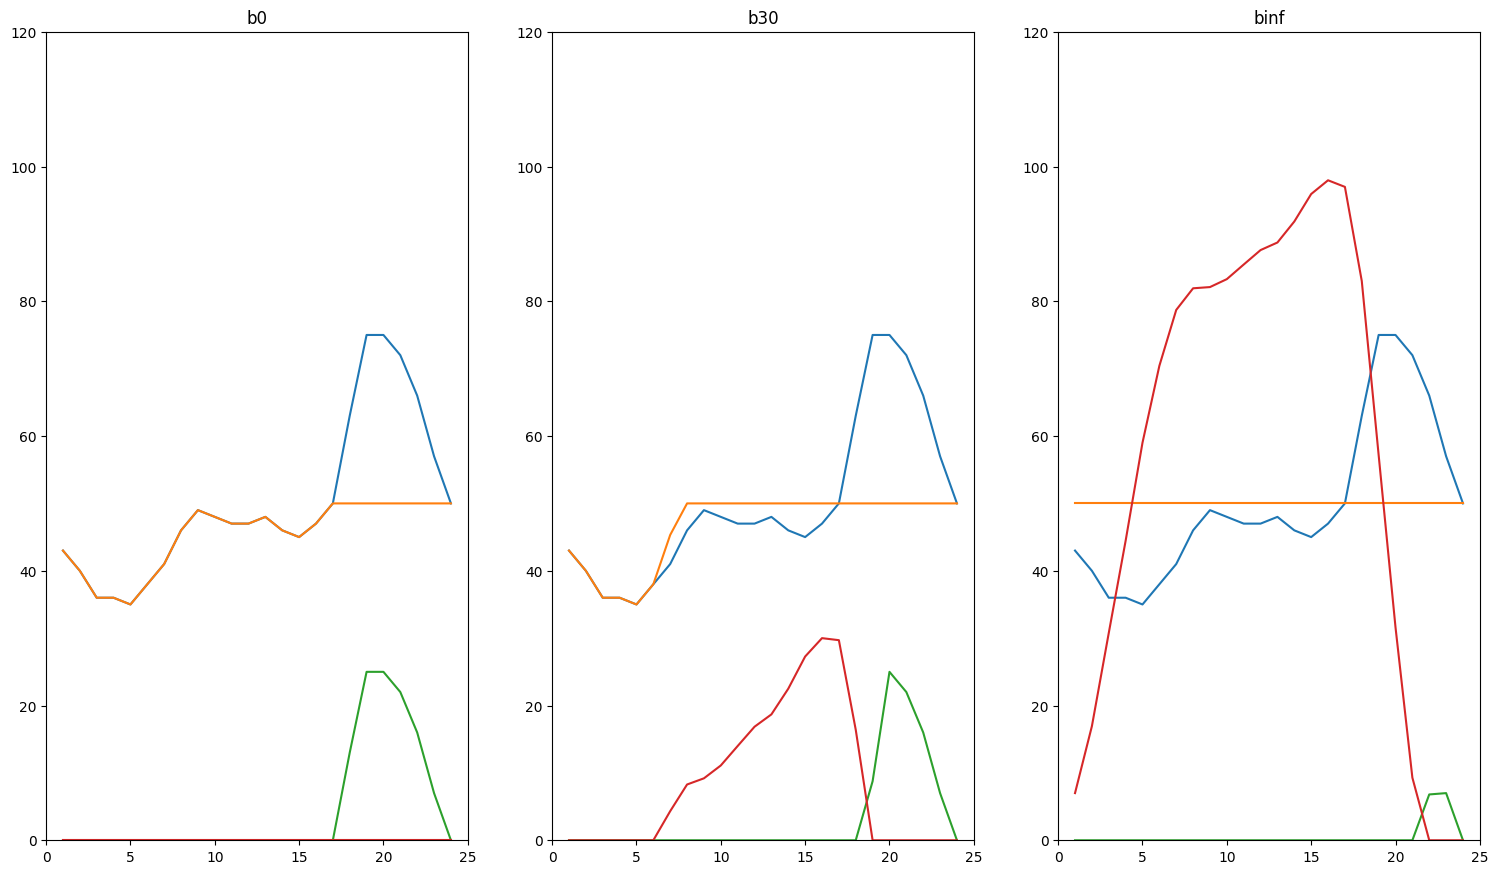

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def change_battery_solve(capacity):
    b.up[hr] = capacity
    powerco.solve()
    if powerco.status != ModelStatus.OptimalGlobal:
        raise GamspyException(
            "Model not solved", powerco.status)
    return ( xl.toDense(), xh.toDense(), b.toDense() )

results = [change_battery_solve(0), change_battery_solve(30), change_battery_solve(3000)]
titles = ['b0', 'b30', 'binf']

fig, ax_lst = plt.subplots(1, 3)

for axis in ax_lst:
    axis.plot(np.linspace(1, 24, 24), daily_need)
    axis.set_xlim(0, 25)
    axis.set_ylim(0, 120)

for i in range(3):
    x_low_b1 =  results[i][0] 
    x_high_b1 = results[i][1] 
    battlev = results[i][2]
    ax_lst[i].plot(np.linspace(1, 24, 24), x_low_b1)
    ax_lst[i].plot(np.linspace(1, 24, 24), x_high_b1)
    ax_lst[i].plot(np.linspace(1, 24, 24), battlev)
    ax_lst[i].set_title(titles[i])
fig.set_size_inches(18.5, 10.5)